Documentation: https://docs.google.com/document/d/1O4SkUmYGDN9H0ihg8iR-hoGGWNPUZ67eWDT2s5GlqU8/edit

In this script, we do accept an initial capital and we use it to limit the number of shares that we buy.

First of all, we have to load our data so we create a function to do so. We are going to get it from YahooFinance.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
from pandas_datareader import data as pdr

def load_data(stock_name, start_date, end_date = []):
    
    yf.pdr_override()
    
    # Start date:
    start_year, start_month, start_day = start_date
    start = dt.datetime(start_year,start_month,start_day)
    
    # End date
    if end_date: 
        end_year, end_month, end_day = end_date
        end = dt.datetime(end_year,end_month,end_day)
    else: # If no data is passed to end_date, we assume it is now 
        end = dt.datetime.now()

    df=pdr.get_data_yahoo(stock_name,start,end)
    
    # To change index from date to num:
    df = df.reset_index()
    
    return df
    
load_data("AAPL",[2022,1,1]).head() # Example

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,177.830002,182.880005,177.710007,182.009995,179.481125,104487900
1,2022-01-04,182.630005,182.940002,179.119995,179.699997,177.203186,99310400
2,2022-01-05,179.610001,180.169998,174.639999,174.919998,172.489624,94537600
3,2022-01-06,172.699997,175.300003,171.639999,172.000000,169.610168,96904000
4,2022-01-07,172.889999,174.139999,171.029999,172.169998,169.777832,86709100


Now, we are going to generate a sample data for the predictions in the selected time range:

In [2]:
import random

def sample_predictions_array(data):
    sample_predictions_df = pd.DataFrame(columns=["Date","Prediction"])
    for value in data.iterrows():
        date = value[1][0]    
        
        num_buy = random.randint(1,10)
        num_sell = random.randint(1,10)
        
        rand_num = random.uniform(0,1)
        if 0 < rand_num < 1/3:
            sample_predictions_df = pd.concat([sample_predictions_df,pd.DataFrame({"Date":[date], "Prediction":["Buy"], "Num Buy":[num_buy] , "Num Sell":[0]})], ignore_index=True)
        elif 1/3 < rand_num < 2/3:
            sample_predictions_df = pd.concat([sample_predictions_df,pd.DataFrame({"Date":[date], "Prediction":["Hold"], "Num Buy":[0] , "Num Sell":[0]})], ignore_index=True)
        elif 2/3 < rand_num < 1:
            sample_predictions_df = pd.concat([sample_predictions_df,pd.DataFrame({"Date":[date], "Prediction":["Sell"], "Num Buy":[0] , "Num Sell":[num_sell]})], ignore_index=True)
    return sample_predictions_df

sample_predictions_array(load_data("AAPL",[2022,1,1])).head()

[*********************100%***********************]  1 of 1 completed


,Date,Prediction,Num Buy,Num Sell
0,2022-01-03,Buy,4.0,0.0
1,2022-01-04,Sell,0.0,5.0
2,2022-01-05,Sell,0.0,4.0
3,2022-01-06,Hold,0.0,0.0
4,2022-01-07,Sell,0.0,4.0


Now we create our backtesting strategy:

In [3]:
import math

def backtest(stock_name, initial_capital, predictions_array, start_date, end_date = []):
    
    # Load the Yahoo Finance data for the time range:
    data = load_data(stock_name, start_date, end_date)

    # The first thing we do is merge both dfs into one to make it more accessible:
    complete_df = pd.merge(data, predictions_array, on="Date")
    
    # Drop the colums we are not going to use:
    complete_df = complete_df.drop("High",axis=1)
    complete_df = complete_df.drop("Low",axis=1)
    complete_df = complete_df.drop("Volume",axis=1)
    complete_df = complete_df.drop("Close",axis=1) # We don't use the Close Price 
    complete_df = complete_df.drop("Adj Close",axis=1) # Nor do we use the Adj Close Price 
    
    # Create the columns we are going to use:
    complete_df["Real Num Buy"] = 0
    complete_df["Amount of shares"] = 0
    complete_df["Invested money ($)"] = 0
    complete_df["Tomorrow's Available money ($)"] = 0
    complete_df["Tomorrow's open - Today's open ($)"] = 0
    complete_df["Daily profit ($)"] = 0
    complete_df["Daily percent profit"] = 0
    complete_df["Net profit ($)"] = 0
    complete_df["Net percent profit"] = 0
    complete_df["Capital ($)"] = 0


    daily_profit = 0
    
    # Backtest:
    for value in complete_df.iterrows():
        # The variables we need to use:
        index = value[0]
        date = value[1][0]
        open_price = value[1][1]
        pred = value[1][2]
        num_buy = value[1][3]
        num_sell = value[1][4]

        if index < (complete_df.shape[0]-1): # Because of how we have constructed our engine, the last day doesn't matter:
            
            if index == 0: # The first day:
                if pred == "Buy":
                    # We check if we have enough money to buy all the shares that we have to:
                    if initial_capital > num_buy*open_price:
                        complete_df.loc[index,"Real Num Buy"] = num_buy
                        complete_df.loc[index,"Amount of shares"] = num_buy
                        complete_df.loc[index,"Invested money ($)"] = num_buy*open_price
                        complete_df.loc[index,"Tomorrow's Available money ($)"] = initial_capital - num_buy*open_price
                    else:
                        # If we don't have enough money, we buy as many as we can:
                        num = math.floor(initial_capital/open_price)
                        complete_df.loc[index,"Real Num Buy"] = num
                        complete_df.loc[index,"Amount of shares"] = num
                        complete_df.loc[index,"Invested money ($)"] = num*open_price
                        complete_df.loc[index,"Tomorrow's Available money ($)"] = initial_capital - num*open_price
                    
                elif pred == "Hold":
                    complete_df.loc[index,"Amount of shares"] = 0
                    complete_df.loc[index,"Tomorrow's Available money ($)"] = initial_capital
            
                elif pred == "Sell":
                    complete_df.loc[index,"Amount of shares"] = 0
                    complete_df.loc[index,"Tomorrow's Available money ($)"] = initial_capital

            else: # The rest of the days:
                if pred == "Buy":
                    # We check if we have enough money to buy all the shares that we have to:
                    if complete_df.loc[index-1,"Tomorrow's Available money ($)"] > num_buy*open_price:
                        complete_df.loc[index,"Real Num Buy"] = num_buy
                        complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"] + num_buy
                        complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"] + num_buy*open_price
                        complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"] - num_buy*open_price
                    else:
                        # If we don't have enough money, we buy as many as we can:

                        #Possible addition might be to borrow money from the bank at the risk free rate (interest rate) and repay with our profits later
                        #Adds a layer of complexity but might be a suitable approach so we do not miss any great trading opportunities
                        #Might have a "strength" factor to our recommendations
                        #if our recommendation is really strong (above a certain threshold) then we borrow money, else we do not buy it 

                        num = math.floor(complete_df.loc[index-1,"Tomorrow's Available money ($)"]/open_price)
                        complete_df.loc[index,"Real Num Buy"] = num
                        complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"] + num
                        complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"] + num*open_price
                        complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"] - num*open_price
                        
                elif pred == "Hold":
                    complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"]
                    complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"]
                    complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"]

                elif pred == "Sell":
                    if complete_df.loc[index-1,"Amount of shares"] > 0: # We check if we have stocks to sell (we don't accept short-selling):

                      #To add for the complete back testing engine: allow short selling
                    
                        if num_sell < complete_df.loc[index-1,"Amount of shares"]: # If we have more stocks than we have to sell:
                            complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"] - num_sell
                            complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"] - num_sell*open_price
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"] + num_sell*open_price

                        else: # If we have less stocks than we have to sell we just sell all of them:
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"] + complete_df.loc[index-1,"Amount of shares"]*open_price
                            complete_df.loc[index,"Amount of shares"] = 0
                            complete_df.loc[index,"Invested money ($)"] = 0 # Set invested money to 0 if we run out of stocks, check the documentation
                                                                            
                            
                    else: # If we don't have stocks to sell we have to update Tomorrow's Available money to the same as the day before:
                        complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"]
                  
                
        # Compute the different metrics:

        if index == 0: # The first day
            complete_df.loc[index,"Tomorrow's open - Today's open ($)"] = complete_df.loc[index+1,"Open"] - complete_df.loc[index,"Open"]
            complete_df.loc[index,"Daily profit ($)"] = complete_df.loc[index,"Tomorrow's open - Today's open ($)"]*complete_df.loc[index,"Amount of shares"]
            complete_df.loc[index,"Net profit ($)"] = complete_df.loc[index,"Daily profit ($)"]
            complete_df.loc[index,"Capital ($)"] = initial_capital + complete_df.loc[index,"Net profit ($)"]
            complete_df.loc[index,"Daily percent profit"] = f'{round((complete_df.loc[index,"Daily profit ($)"]/initial_capital)*100,2)}%'
            complete_df.loc[index,"Net percent profit"] = f'{round((complete_df.loc[index,"Capital ($)"]/initial_capital-1)*100,2)}%'
            
        elif index < (complete_df.shape[0]-1): # All the days except the first and the last one
            complete_df.loc[index,"Tomorrow's open - Today's open ($)"] = complete_df.loc[index+1,"Open"] - complete_df.loc[index,"Open"]
            complete_df.loc[index,"Daily profit ($)"] = complete_df.loc[index,"Tomorrow's open - Today's open ($)"]*complete_df.loc[index,"Amount of shares"]
            complete_df.loc[index,"Net profit ($)"] = complete_df.loc[index-1,"Net profit ($)"] + complete_df.loc[index,"Daily profit ($)"]
            complete_df.loc[index,"Capital ($)"] = initial_capital + complete_df.loc[index,"Net profit ($)"]
            complete_df.loc[index,"Daily percent profit"] = f'{round((complete_df.loc[index,"Daily profit ($)"]/complete_df.loc[index-1,"Capital ($)"])*100,2)}%'
            complete_df.loc[index,"Net percent profit"] = f'{round((complete_df.loc[index,"Capital ($)"]/initial_capital-1)*100,2)}%'
            
        else: # The last day
            complete_df.loc[index,"Net profit ($)"] = complete_df.loc[index-1,"Net profit ($)"]
            complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"]
            complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"]
            complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"]
            complete_df.loc[index,"Capital ($)"] = initial_capital + complete_df.loc[index,"Net profit ($)"]
            complete_df.loc[index,"Net percent profit"] = f'{round((complete_df.loc[index,"Capital ($)"]/initial_capital-1)*100,2)}%'
            # What we set to NaN because doesn't appear on the last day:
            complete_df.loc[index,"Daily profit ($)"] = np.nan 
            complete_df.loc[index,"Prediction"] = np.nan
            complete_df.loc[index,"Num Buy"] = np.nan
            complete_df.loc[index,"Num Sell"] = np.nan
            complete_df.loc[index,"Real Num Buy"] = np.nan
            complete_df.loc[index,"Tomorrow's open - Today's open ($)"] = np.nan
            complete_df.loc[index,"Daily percent profit"] = np.nan

        
        # We need to update the invested money by the daily profit of that day:
        if index < (complete_df.shape[0]-1):
            complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index,"Invested money ($)"] + complete_df.loc[index,"Daily profit ($)"]
        
        
    
        # Some security measures to see if everything is okay:
        
#         if complete_df.loc[index,"Real Num Buy"] != complete_df.loc[index,"Num Buy"] and index != (complete_df.shape[0]-1):
#             print(date)
            
        if complete_df.loc[index,"Tomorrow's Available money ($)"] < 0:
            print("Negative available money:",date)        
        
        if complete_df.loc[index,"Invested money ($)"] < 0:
            print("Something failed")
            print(date)
    
        if abs(complete_df.loc[index,"Tomorrow's Available money ($)"] + complete_df.loc[index,"Invested money ($)"] - complete_df.loc[index,"Capital ($)"]) > 0.5:
            print("Problem")
            print(date)
    

    # We round these columns to have them cleaner and we do it here so the precision in the decimals doesn't affect the results:  
    complete_df["Tomorrow's open - Today's open ($)"] = round(complete_df["Tomorrow's open - Today's open ($)"],3)
    complete_df["Daily profit ($)"] = round(complete_df["Daily profit ($)"],3)
    complete_df["Invested money ($)"] = round(complete_df["Invested money ($)"],3)
    complete_df["Net profit ($)"] = round(complete_df["Net profit ($)"],3)
    complete_df["Capital ($)"] = round(complete_df["Capital ($)"],3)
    complete_df["Tomorrow's Available money ($)"] = round(complete_df["Tomorrow's Available money ($)"],3)
    
    print(f"\nNet profit in the selected period: {complete_df.loc[index,'Net profit ($)']}$")   

    return complete_df
    

The logic used for the daily profit is that we buy/sell at the start of the day, so the daily profit is computed as the amount of shares we have that day multplied by the difference between the open price the next day and the open price for the stock that day. Therefore, selling or buying stocks doesn't affect to our profit but only does it the change in the price of that stock between the open price of that day and the open price of the next day.

# Possible addition:

Common thing to do in wall street is to buy at the middle of the day and sell at the end of the day. 

To simplify this, we can buy at the beggining and sell at the end 

Now, we test the backtesting strategy using a random sample of predictions:

In [7]:
stock_name_sample = "AMZN"
start_date_sample = [2018,1,1]
end_date_sample = [2020,8,1]

#random.seed(29)

data_sample = load_data(stock_name_sample, start_date_sample,end_date_sample)
predictions_sample = sample_predictions_array(data_sample)

data = backtest(stock_name_sample,10000,predictions_sample,start_date_sample,end_date_sample)
# data.to_excel("data.xlsx")
data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Net profit in the selected period: 920.562$


,Date,Open,Prediction,Num Buy,Num Sell,Real Num Buy,Amount of shares,Invested money ($),Tomorrow's Available money ($),Tomorrow's open - Today's open ($),Daily profit ($),Daily percent profit,Net profit ($),Net percent profit,Capital ($)
0,2018-01-02,58.599998,Buy,6.0,0.0,6.0,6,356.490,9648.400,0.815,4.890,0.05%,4.890,0.05%,10004.890
1,2018-01-03,59.415001,Sell,0.0,5.0,0.0,1,60.250,9945.475,0.835,0.835,0.01%,5.725,0.06%,10005.725
2,2018-01-04,60.250000,Sell,0.0,2.0,0.0,0,0.000,10005.725,0.625,0.000,0.0%,5.725,0.06%,10005.725
3,2018-01-05,60.875500,Sell,0.0,8.0,0.0,0,0.000,10005.725,0.924,0.000,0.0%,5.725,0.06%,10005.725
4,2018-01-08,61.799999,Sell,0.0,1.0,0.0,0,0.000,10005.725,1.045,0.000,0.0%,5.725,0.06%,10005.725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,2020-07-27,153.100006,Sell,0.0,4.0,0.0,9,1374.422,9454.405,-0.387,-3.479,-0.03%,828.827,8.29%,10828.827
646,2020-07-28,152.713501,Buy,7.0,0.0,7.0,16,2424.792,8385.411,-1.164,-18.624,-0.17%,810.203,8.1%,10810.203
647,2020-07-29,151.549500,Buy,3.0,0.0,3.0,19,2863.300,7930.762,-0.850,-16.141,-0.15%,794.062,7.94%,10794.062
648,2020-07-30,150.699997,Sell,0.0,8.0,0.0,11,1784.200,9136.362,11.500,126.500,1.17%,920.562,9.21%,10920.562


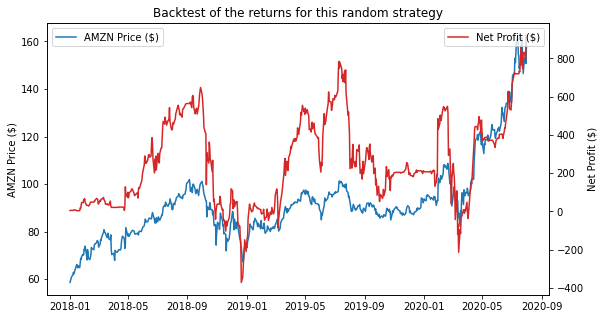

In [16]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(9, 5))
ax1.set_ylabel(f"{stock_name_sample} Price ($)")
ax1.plot(data["Date"], data["Open"], color='tab:blue', label=f"{stock_name_sample} Price ($)")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel("Net Profit ($)")
ax2.plot(data["Date"], data["Net profit ($)"], color='tab:red', label="Net Profit ($)")
ax2.legend(loc='upper right')

plt.title("Backtest of the returns for this random strategy")
plt.show()
